In [144]:
import pandas as pd
import numpy as np
from datetime import datetime

In [145]:
df = pd.read_csv('202307-citibike-tripdata.csv')

/var/folders/j1/1yf4p72d5qn097_6xdrl6cf00000gn/T/ipykernel_51749/604118675.py:1: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('202307-citibike-tripdata.csv')


In [146]:
df.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,BC78328130CD8A16,classic_bike,2023-07-16 20:42:57,2023-07-16 20:45:13,St. Nicholas Ave & W 126 St,7756.10,Adam Clayton Powell Blvd & W 126 St,7738.04,40.811432,-73.951878,40.809495,-73.947765,member
1,71A4DFA231ADAEA2,classic_bike,2023-07-29 12:22:21,2023-07-29 12:26:54,Adam Clayton Powell Blvd & W 118 St,7670.09,Adam Clayton Powell Blvd & W 126 St,7738.04,40.804372,-73.951475,40.809495,-73.947765,member
2,B64451D0D9F52134,classic_bike,2023-07-30 18:30:18,2023-07-30 18:35:42,St. Nicholas Ave & W 126 St,7756.10,Lenox Ave & W 130 St,7753.13,40.811378,-73.951827,40.810792,-73.943068,member
3,EEECB3E0E05EB0DB,classic_bike,2023-07-04 19:59:20,2023-07-04 20:02:03,St. Nicholas Ave & W 126 St,7756.10,Adam Clayton Powell Blvd & W 126 St,7738.04,40.811432,-73.951878,40.809495,-73.947765,member
4,76B706DF4FC180DC,classic_bike,2023-07-03 19:33:36,2023-07-03 19:43:59,St. Nicholas Ave & W 126 St,7756.10,Pleasant Ave & E 116 St,7450.05,40.811543,-73.951813,40.794988,-73.933335,member


In [198]:
# Convert the strings to datetime objects
date_format = "%Y-%m-%d %H:%M:%S"
df['started_at'] = pd.to_datetime(df['started_at'], format=date_format)
df['ended_at'] = pd.to_datetime(df['ended_at'], format=date_format)

# Calculate the time difference as a timedelta
df['ride_time'] = df['ended_at'] - df['started_at']

# Convert the time difference to minutes
df['ride_time'] = df['ride_time'].dt.total_seconds() / 60

print(df.shape)
df.head()

(3776256, 14)


,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,ride_time
0,BC78328130CD8A16,classic_bike,2023-07-16 20:42:57,2023-07-16 20:45:13,St. Nicholas Ave & W 126 St,7756.10,Adam Clayton Powell Blvd & W 126 St,7738.04,40.811432,-73.951878,40.809495,-73.947765,member,2.266667
1,71A4DFA231ADAEA2,classic_bike,2023-07-29 12:22:21,2023-07-29 12:26:54,Adam Clayton Powell Blvd & W 118 St,7670.09,Adam Clayton Powell Blvd & W 126 St,7738.04,40.804372,-73.951475,40.809495,-73.947765,member,4.550000
2,B64451D0D9F52134,classic_bike,2023-07-30 18:30:18,2023-07-30 18:35:42,St. Nicholas Ave & W 126 St,7756.10,Lenox Ave & W 130 St,7753.13,40.811378,-73.951827,40.810792,-73.943068,member,5.400000
3,EEECB3E0E05EB0DB,classic_bike,2023-07-04 19:59:20,2023-07-04 20:02:03,St. Nicholas Ave & W 126 St,7756.10,Adam Clayton Powell Blvd & W 126 St,7738.04,40.811432,-73.951878,40.809495,-73.947765,member,2.716667
4,76B706DF4FC180DC,classic_bike,2023-07-03 19:33:36,2023-07-03 19:43:59,St. Nicholas Ave & W 126 St,7756.10,Pleasant Ave & E 116 St,7450.05,40.811543,-73.951813,40.794988,-73.933335,member,10.383333


In [199]:
# Drop ride times > 3 hrs

df_final = df[df['ride_time'] < 180]
df_final = df_final.reset_index(drop=True)

# Drop ride times < 0 minutes

df_final = df_final[df_final['ride_time'] >= 0]

print(df_final.shape)
df_final.head()

(3766773, 14)


,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,ride_time
0,BC78328130CD8A16,classic_bike,2023-07-16 20:42:57,2023-07-16 20:45:13,St. Nicholas Ave & W 126 St,7756.10,Adam Clayton Powell Blvd & W 126 St,7738.04,40.811432,-73.951878,40.809495,-73.947765,member,2.266667
1,71A4DFA231ADAEA2,classic_bike,2023-07-29 12:22:21,2023-07-29 12:26:54,Adam Clayton Powell Blvd & W 118 St,7670.09,Adam Clayton Powell Blvd & W 126 St,7738.04,40.804372,-73.951475,40.809495,-73.947765,member,4.550000
2,B64451D0D9F52134,classic_bike,2023-07-30 18:30:18,2023-07-30 18:35:42,St. Nicholas Ave & W 126 St,7756.10,Lenox Ave & W 130 St,7753.13,40.811378,-73.951827,40.810792,-73.943068,member,5.400000
3,EEECB3E0E05EB0DB,classic_bike,2023-07-04 19:59:20,2023-07-04 20:02:03,St. Nicholas Ave & W 126 St,7756.10,Adam Clayton Powell Blvd & W 126 St,7738.04,40.811432,-73.951878,40.809495,-73.947765,member,2.716667
4,76B706DF4FC180DC,classic_bike,2023-07-03 19:33:36,2023-07-03 19:43:59,St. Nicholas Ave & W 126 St,7756.10,Pleasant Ave & E 116 St,7450.05,40.811543,-73.951813,40.794988,-73.933335,member,10.383333


### Warm Up Questions:

<b>1. Using the start time and end time, compute the duration of each ride in minutes and plot the histogram of ride durations.</b>

36


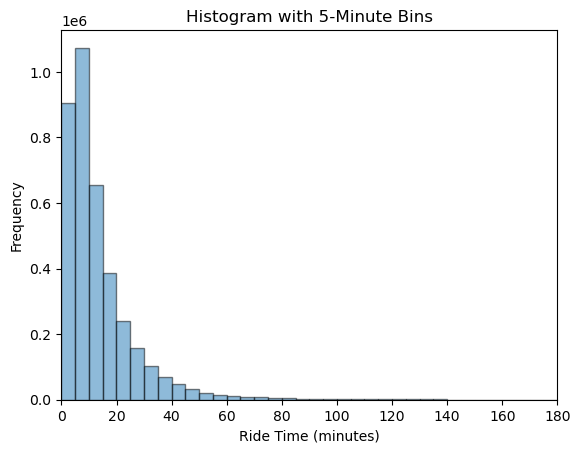

In [200]:
import matplotlib.pyplot as plt

# Calculate the number of bins
bin_size = 5
num_bins = int((max(df_final['ride_time']) - min(df_final['ride_time'])) / bin_size) + 1

print(num_bins)

# Create the histogram
plt.hist(df_final['ride_time'], bins=num_bins, edgecolor='k', alpha=0.5)

# Set labels and title
plt.xlabel('Ride Time (minutes)')
plt.ylabel('Frequency')
plt.title('Histogram with 5-Minute Bins')

# Show the plot
plt.xlim(0, 180)
plt.show()

<b>2. What is the expected ride duration (i.e., the average ride duration)? What is the empirical variance of ride duration? What is the probability that a ride duration is greater than 20 min?</b>

In [201]:
### Empirical Average

average = df_final['ride_time'].sum() / df_final.shape[0]

print("E (X): {}".format(average))

### Empirical Variance

df_final['ride_time - avg'] = (df['ride_time'] - average)**2

variance = df_final['ride_time - avg'].sum() / df_final.shape[0]

print("Var (X): {}".format(df['ride_time'].var()))

### P ( X > 20 )

count_greater_20 = (df_final['ride_time'] > 20).sum() 

prob_greater_20 = count_greater_20 / df_final.shape[0]

print("P (X > 20): {}".format(prob_greater_20))

E (X): 13.645103961224448
Var (X): 6825.868707355557
P (X > 20): 0.19749424772875881


<b>3. What is the probability that a ride duration is greater than 20 min conditioning on the fact that the user is a CitiBike member? Note that the last column gives whether the ride is for a casual client or a CitiBike member.</b>

In [202]:
### P ( X > 20 | User = member )

count_greater_20_member = ((df_final['ride_time'] > 20) & (df_final['member_casual'] == 'member')).sum()

count_member = (df_final['member_casual'] == 'member').sum()

prob_greater_20_member = count_greater_20_member / count_member

print("P (X > 20 | User = member): {}".format(prob_greater_20_member))

P (X > 20 | User = member): 0.15541528843070582


<b>4. Suppose that the duration of some ride is more than 25min. What is the probability that this ride belongs to a CitiBike member?</b>

In [203]:
### P ( User = member | X > 25 )

count_greater_25_member = ((df_final['ride_time'] > 25) & (df_final['member_casual'] == 'member')).sum()

count_greater_25 = (df_final['ride_time'] > 25).sum() 

prob_member_greater_25 = count_greater_25_member / count_greater_25

print("P (User = member | X > 25): {}".format(prob_member_greater_25))

P (User = member | X > 25): 0.5786827930838001


<b>5. What is the expected ride duration of an electric bike? What is the expected ride duration of a classic bike?</b>

In [204]:
### Empirical Average of Electric bike

df_electric = pd.DataFrame()

df_electric = df_final[df_final['rideable_type'] == 'electric_bike']

average_electric = df_electric['ride_time'].sum() / df_electric.shape[0]

print("E (X_electric): {}".format(average_electric))


### Empirical Average of Classic bike

df_classic = pd.DataFrame()

df_classic = pd.DataFrame(df_final[df_final['rideable_type'] == 'classic_bike'])

average_classic = df_classic['ride_time'].sum() / df_classic.shape[0]

print("E (X_classic): {}".format(average_classic))

E (X_electric): 12.275573339870734
E (X_classic): 13.726936409451845


<b>6. Suppose that the duration of some ride is less than 10min. What is the probability that this ride uses an electric bike? What is the probability that this ride uses a classic bike? Comment on the results.</b>

In [205]:
### P (Bike = electric | X < 10)

count_electric_less_10 = ((df_final['ride_time'] < 10) & (df_final['rideable_type'] == 'electric_bike')).sum()

count_less_10 = (df_final['ride_time'] < 10).sum() 

prob_electric_less_10 = count_electric_less_10 / count_less_10

print("P (Bike = electric | X < 10): {}".format(prob_electric_less_10))


### P (Bike = classic | X < 10)

count_classic_less_10 = ((df_final['ride_time'] < 10) & (df_final['rideable_type'] == 'classic_bike')).sum()

count_less_10 = (df_final['ride_time'] < 10).sum() 

prob_classic_less_10 = count_classic_less_10 / count_less_10

print("P (Bike = classic | X < 10): {}".format(prob_classic_less_10))

P (Bike = electric | X < 10): 0.08921455992944956
P (Bike = classic | X < 10): 0.9101715621826949


People used classic bikes more so than electric bikes for rides less than 10 min.

In [206]:
print("Classic: {}".format(df_classic.shape[0]))
print("Electric: {}".format(df_electric.shape[0]))

Classic: 3448285
Electric: 310011


### Project Code

In [207]:
# Selecting top 3 stations with most frequent rides in / out

df_final['start_station_name'].value_counts()

W 21 St & 6 Ave                                 13599
West St & Chambers St                           12976
Broadway & W 58 St                              12419
11 Ave & W 41 St                                11965
7 Ave & Central Park South                      11876
                                                ...  
2 St & Park Ave                                     1
Communipaw & Berry Lane                             1
Schenectady Ave & Cortelyou Rd                      1
Southwest Park - Jackson St & Observer Hwy          1
South Waterfront Walkway - Sinatra Dr & 1 St        1
Name: start_station_name, Length: 1936, dtype: int64

In [208]:
df_final['end_station_name'].value_counts()

W 21 St & 6 Ave                      13665
West St & Chambers St                13002
Broadway & W 58 St                   12035
11 Ave & W 41 St                     11977
7 Ave & Central Park South           11392
                                     ...  
Brunswick & 6th                          1
Jersey & 6th St                          1
Schenectady Ave & Cortelyou Rd           1
Van Vorst Park                           1
Columbus Park - Clinton St & 9 St        1
Name: end_station_name, Length: 1952, dtype: int64

In [209]:
len(df_final)

3766773

In [210]:
# finalized stations: need to extract only these from df_final
#'W 21 St & 6 Ave' = 6140.05
#'West St & Chambers St' = 5329.03
#'Broadway & W 58 St' = 6948.1

df_final = df_final[((df_final['start_station_name'] == 'W 21 St & 6 Ave')
                     | (df_final['start_station_name'] == 'West St & Chambers St')
                     | (df_final['start_station_name'] == 'Broadway & W 58 St')
                     | (df_final['end_station_name'] == 'W 21 St & 6 Ave')
                     | (df_final['end_station_name'] == 'West St & Chambers St')
                     | (df_final['end_station_name'] == 'Broadway & W 58 St'))]


df_final.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,ride_time,ride_time - avg
1203,1A16C593C6EB804E,classic_bike,2023-07-19 06:27:35,2023-07-19 06:31:28,W 21 St & 6 Ave,6140.05,W 20 St & 10 Ave,6306.01,40.741740,-73.994156,40.745686,-74.005141,member,3.883333,51.052511
1204,136BD3B987A0F6DE,classic_bike,2023-07-31 18:16:42,2023-07-31 18:19:59,W 21 St & 6 Ave,6140.05,W 20 St & 10 Ave,6306.01,40.741691,-73.994053,40.745686,-74.005141,member,3.283333,123.101332
1205,6535B992A72AB451,classic_bike,2023-07-22 13:02:09,2023-07-22 13:06:21,W 21 St & 6 Ave,6140.05,W 20 St & 10 Ave,6306.01,40.741740,-73.994156,40.745686,-74.005141,member,4.200000,95.292166
1206,316ADEF20D589A1E,classic_bike,2023-07-28 12:11:55,2023-07-28 12:15:46,W 21 St & 6 Ave,6140.05,W 20 St & 10 Ave,6306.01,40.741740,-73.994156,40.745686,-74.005141,member,3.850000,107.366291
1686,C3F39D56EC95277C,classic_bike,2023-07-25 15:29:46,2023-07-25 15:32:57,W 21 St & 6 Ave,6140.05,W 17 St & 7 Ave,6107.08,40.741740,-73.994156,40.740564,-73.998526,member,3.183333,456.031585


In [211]:
len(df_final)

75134

In [212]:
# Separate date and time into different columns
df_final['start_date'] = df_final['started_at'].dt.date
df_final['start_time'] = df_final['started_at'].dt.time
df_final['end_date'] = df_final['ended_at'].dt.date
df_final['end_time'] = df_final['ended_at'].dt.time

df_final.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,ride_time,ride_time - avg,start_date,start_time,end_date,end_time
1203,1A16C593C6EB804E,classic_bike,2023-07-19 06:27:35,2023-07-19 06:31:28,W 21 St & 6 Ave,6140.05,W 20 St & 10 Ave,6306.01,40.741740,-73.994156,40.745686,-74.005141,member,3.883333,51.052511,2023-07-19,06:27:35,2023-07-19,06:31:28
1204,136BD3B987A0F6DE,classic_bike,2023-07-31 18:16:42,2023-07-31 18:19:59,W 21 St & 6 Ave,6140.05,W 20 St & 10 Ave,6306.01,40.741691,-73.994053,40.745686,-74.005141,member,3.283333,123.101332,2023-07-31,18:16:42,2023-07-31,18:19:59
1205,6535B992A72AB451,classic_bike,2023-07-22 13:02:09,2023-07-22 13:06:21,W 21 St & 6 Ave,6140.05,W 20 St & 10 Ave,6306.01,40.741740,-73.994156,40.745686,-74.005141,member,4.200000,95.292166,2023-07-22,13:02:09,2023-07-22,13:06:21
1206,316ADEF20D589A1E,classic_bike,2023-07-28 12:11:55,2023-07-28 12:15:46,W 21 St & 6 Ave,6140.05,W 20 St & 10 Ave,6306.01,40.741740,-73.994156,40.745686,-74.005141,member,3.850000,107.366291,2023-07-28,12:11:55,2023-07-28,12:15:46
1686,C3F39D56EC95277C,classic_bike,2023-07-25 15:29:46,2023-07-25 15:32:57,W 21 St & 6 Ave,6140.05,W 17 St & 7 Ave,6107.08,40.741740,-73.994156,40.740564,-73.998526,member,3.183333,456.031585,2023-07-25,15:29:46,2023-07-25,15:32:57


In [213]:
# Filtering out weekends (Saturday and Sunday). Select only those rides that start on Mon, Tue, Wed, Thu or Fri.
df_final['start_date'] = pd.to_datetime(df_final['start_date'])

df_final = df_final[(df_final['start_date'].dt.weekday < 5)]

len(df_final)
df_final.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,ride_time,ride_time - avg,start_date,start_time,end_date,end_time
1203,1A16C593C6EB804E,classic_bike,2023-07-19 06:27:35,2023-07-19 06:31:28,W 21 St & 6 Ave,6140.05,W 20 St & 10 Ave,6306.01,40.741740,-73.994156,40.745686,-74.005141,member,3.883333,51.052511,2023-07-19,06:27:35,2023-07-19,06:31:28
1204,136BD3B987A0F6DE,classic_bike,2023-07-31 18:16:42,2023-07-31 18:19:59,W 21 St & 6 Ave,6140.05,W 20 St & 10 Ave,6306.01,40.741691,-73.994053,40.745686,-74.005141,member,3.283333,123.101332,2023-07-31,18:16:42,2023-07-31,18:19:59
1206,316ADEF20D589A1E,classic_bike,2023-07-28 12:11:55,2023-07-28 12:15:46,W 21 St & 6 Ave,6140.05,W 20 St & 10 Ave,6306.01,40.741740,-73.994156,40.745686,-74.005141,member,3.850000,107.366291,2023-07-28,12:11:55,2023-07-28,12:15:46
1686,C3F39D56EC95277C,classic_bike,2023-07-25 15:29:46,2023-07-25 15:32:57,W 21 St & 6 Ave,6140.05,W 17 St & 7 Ave,6107.08,40.741740,-73.994156,40.740564,-73.998526,member,3.183333,456.031585,2023-07-25,15:29:46,2023-07-25,15:32:57
1689,A872FE851E458C41,classic_bike,2023-07-28 18:31:33,2023-07-28 18:45:21,W 21 St & 6 Ave,6140.05,Cleveland Pl & Spring St,5492.05,40.741740,-73.994156,40.722104,-73.997249,member,13.800000,178.798689,2023-07-28,18:31:33,2023-07-28,18:45:21


In [214]:
# Defining the time range for morning / rest will automatically be evening
start_time = pd.to_datetime('00:00:00').time()
end_time = pd.to_datetime('14:00:00').time()

df_final_morning = df_final[((df_final['start_time'] >= start_time) & (df_final['end_time'] < end_time))]

df_final_morning

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,ride_time,ride_time - avg,start_date,start_time,end_date,end_time
1203,1A16C593C6EB804E,classic_bike,2023-07-19 06:27:35,2023-07-19 06:31:28,W 21 St & 6 Ave,6140.05,W 20 St & 10 Ave,6306.01,40.741740,-73.994156,40.745686,-74.005141,member,3.883333,51.052511,2023-07-19,06:27:35,2023-07-19,06:31:28
1206,316ADEF20D589A1E,classic_bike,2023-07-28 12:11:55,2023-07-28 12:15:46,W 21 St & 6 Ave,6140.05,W 20 St & 10 Ave,6306.01,40.741740,-73.994156,40.745686,-74.005141,member,3.850000,107.366291,2023-07-28,12:11:55,2023-07-28,12:15:46
2439,46B81A6426E7AE83,classic_bike,2023-07-12 11:59:48,2023-07-12 12:05:42,W 21 St & 6 Ave,6140.05,W 29 St & 9 Ave,6416.06,40.741740,-73.994156,40.750073,-73.998393,member,5.900000,65.530708,2023-07-12,11:59:48,2023-07-12,12:05:42
2524,45B9657D6D1006DA,classic_bike,2023-07-05 08:49:32,2023-07-05 09:02:51,Broadway & W 58 St,6948.10,W 52 St & 5 Ave,6700.01,40.766953,-73.981693,40.759923,-73.976485,member,13.316667,0.068524,2023-07-05,08:49:32,2023-07-05,09:02:51
2548,75A168CB1318C71A,classic_bike,2023-07-21 08:53:44,2023-07-21 09:09:49,Broadway & W 58 St,6948.10,1 Ave & E 39 St,6303.01,40.767130,-73.981919,40.747140,-73.971130,member,16.083333,270.763604,2023-07-21,08:53:44,2023-07-21,09:09:49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3764134,A98B93B9C579D764,classic_bike,2023-07-28 13:18:34,2023-07-28 13:31:49,Broadway & W 58 St,6948.1,W 25 St & 6 Ave,6215.04,40.766950,-73.982489,40.743954,-73.991449,casual,13.250000,13.901245,2023-07-28,13:18:34,2023-07-28,13:31:49
3764686,B85A4C7F9A8439F1,classic_bike,2023-07-13 12:50:05,2023-07-13 13:02:47,Broadway & W 58 St,6948.1,W 46 St & 11 Ave,6795.01,40.766953,-73.981693,40.763414,-73.996674,casual,12.700000,48.466250,2023-07-13,12:50:05,2023-07-13,13:02:47
3764987,F7F0D7DA520093ED,classic_bike,2023-07-07 11:34:21,2023-07-07 12:57:58,Broadway & W 58 St,6948.1,Main St & Plymouth St,4936.21,40.767611,-73.981562,40.703782,-73.990734,casual,83.616667,65.530708,2023-07-07,11:34:21,2023-07-07,12:57:58
3764988,500262A9B28A510C,classic_bike,2023-07-07 11:34:34,2023-07-07 12:57:55,Broadway & W 58 St,6948.1,Main St & Plymouth St,4936.21,40.767416,-73.981544,40.703782,-73.990734,casual,83.350000,15.301949,2023-07-07,11:34:34,2023-07-07,12:57:55


In [215]:
df_final_evening = pd.merge(df_final, df_final_morning, how='outer', indicator=True).loc[lambda x: x['_merge'] == 'left_only']

# Drop the indicator column and reset the index if needed
df_final_evening = df_final_evening.drop('_merge', axis=1).reset_index(drop=True)
    
df_final_evening

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,ride_time,ride_time - avg,start_date,start_time,end_date,end_time
0,136BD3B987A0F6DE,classic_bike,2023-07-31 18:16:42,2023-07-31 18:19:59,W 21 St & 6 Ave,6140.05,W 20 St & 10 Ave,6306.01,40.741691,-73.994053,40.745686,-74.005141,member,3.283333,123.101332,2023-07-31,18:16:42,2023-07-31,18:19:59
1,C3F39D56EC95277C,classic_bike,2023-07-25 15:29:46,2023-07-25 15:32:57,W 21 St & 6 Ave,6140.05,W 17 St & 7 Ave,6107.08,40.741740,-73.994156,40.740564,-73.998526,member,3.183333,456.031585,2023-07-25,15:29:46,2023-07-25,15:32:57
2,A872FE851E458C41,classic_bike,2023-07-28 18:31:33,2023-07-28 18:45:21,W 21 St & 6 Ave,6140.05,Cleveland Pl & Spring St,5492.05,40.741740,-73.994156,40.722104,-73.997249,member,13.800000,178.798689,2023-07-28,18:31:33,2023-07-28,18:45:21
3,6D25321952FFD60A,classic_bike,2023-07-13 16:36:00,2023-07-13 16:40:58,W 21 St & 6 Ave,6140.05,8 Ave & W 24 St,6224.06,40.741740,-73.994156,40.745911,-73.998071,member,4.966667,78.235864,2023-07-13,16:36:00,2023-07-13,16:40:58
4,B64BE6B0E3F4EA9C,classic_bike,2023-07-31 18:48:58,2023-07-31 18:53:03,W 21 St & 6 Ave,6140.05,Perry St & Bleecker St,5922.07,40.741609,-73.994118,40.735354,-74.004831,member,4.083333,394.216897,2023-07-31,18:48:58,2023-07-31,18:53:03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33741,ECAEEADDA202A9F7,electric_bike,2023-07-07 15:04:23,2023-07-07 15:17:57,Broadway & W 58 St,6948.1,W 46 St & 11 Ave,6795.01,40.766953,-73.981693,40.763414,-73.996674,member,13.566667,130.609179,2023-07-07,15:04:23,2023-07-07,15:17:57
33742,064D59BB1CDE6AFA,classic_bike,2023-07-27 15:59:06,2023-07-27 16:16:13,Broadway & W 58 St,6948.1,5 Ave & E 93 St,7372.10,40.766953,-73.981693,40.785785,-73.957481,member,17.116667,149.127342,2023-07-27,15:59:06,2023-07-27,16:16:13
33743,DAC033075E9A2B8D,classic_bike,2023-07-20 16:51:41,2023-07-20 17:08:09,Broadway & W 58 St,6948.1,Central Park W & W 97 St,7538.18,40.766953,-73.981693,40.792495,-73.964171,member,16.466667,94.967051,2023-07-20,16:51:41,2023-07-20,17:08:09
33744,9B3F78BDA64A666C,classic_bike,2023-07-05 16:32:25,2023-07-05 16:51:37,Broadway & W 58 St,6948.1,Mt Morris Park W & W 120 St,7685.14,40.766039,-73.981913,40.804038,-73.945925,member,19.200000,0.198118,2023-07-05,16:32:25,2023-07-05,16:51:37


In [217]:
df_station_1_morning = df_final_morning[((df_final_morning['start_station_name'] == 'W 21 St & 6 Ave')
                     | (df_final_morning['end_station_name'] == 'W 21 St & 6 Ave'))]
df_station_2_morning = df_final_morning[((df_final_morning['start_station_name'] == 'West St & Chambers St')
                     | (df_final_morning['end_station_name'] == 'West St & Chambers St'))]
df_station_3_morning = df_final_morning[((df_final_morning['start_station_name'] == 'Broadway & W 58 St')
                     | (df_final_morning['end_station_name'] == 'Broadway & W 58 St'))]

df_station_1_evening = df_final_evening[((df_final_evening['start_station_name'] == 'W 21 St & 6 Ave')
                     | (df_final_evening['end_station_name'] == 'W 21 St & 6 Ave'))]
df_station_2_evening = df_final_evening[((df_final_evening['start_station_name'] == 'West St & Chambers St')
                     | (df_final_evening['end_station_name'] == 'West St & Chambers St'))]
df_station_3_evening = df_final_evening[((df_final_evening['start_station_name'] == 'Broadway & W 58 St')
                     | (df_final_evening['end_station_name'] == 'Broadway & W 58 St'))]

In [220]:
df_station_2_evening

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,ride_time,ride_time - avg,start_date,start_time,end_date,end_time
81,F6CA82F2EE875E5C,classic_bike,2023-07-13 19:08:31,2023-07-13 19:24:00,West St & Chambers St,5329.03,W 21 St & 6 Ave,6140.05,40.717548,-74.013221,40.741740,-73.994156,member,15.483333,22.044001,2023-07-13,19:08:31,2023-07-13,19:24:00
115,FE7E03AB8C231EF5,classic_bike,2023-07-17 22:28:48,2023-07-17 22:45:54,West St & Chambers St,5329.03,Maiden Ln & Pearl St,5065.10,40.718040,-74.013065,40.707065,-74.007319,casual,17.100000,46.627556,2023-07-17,22:28:48,2023-07-17,22:45:54
119,0A243735AE7154A2,classic_bike,2023-07-05 17:58:02,2023-07-05 18:02:52,West St & Chambers St,5329.03,Pier 40 - Hudson River Park,5696.03,40.717548,-74.013221,40.727714,-74.011296,casual,4.833333,454.609036,2023-07-05,17:58:02,2023-07-05,18:02:52
120,5E6C269DFF0B1BAA,electric_bike,2023-07-04 21:56:44,2023-07-04 22:03:53,West St & Chambers St,5329.03,Pier 40 - Hudson River Park,5696.03,40.717548,-74.013221,40.727714,-74.011296,casual,7.150000,32.244650,2023-07-04,21:56:44,2023-07-04,22:03:53
121,E28557ECBE11D1E3,classic_bike,2023-07-11 15:44:46,2023-07-11 15:59:47,West St & Chambers St,5329.03,W 36 St & 9 Ave,6569.07,40.717747,-74.013077,40.754623,-73.995168,casual,15.016667,152.813373,2023-07-11,15:44:46,2023-07-11,15:59:47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33705,53BEBDE405B4416E,classic_bike,2023-07-20 21:21:43,2023-07-20 21:45:38,West St & Chambers St,5329.03,W 46 St & 11 Ave,6795.01,40.717548,-74.013221,40.763414,-73.996674,casual,23.916667,20.444529,2023-07-20,21:21:43,2023-07-20,21:45:38
33706,6B67B14861B9BEF3,classic_bike,2023-07-17 17:22:43,2023-07-17 17:40:14,West St & Chambers St,5329.03,W 25 St & 6 Ave,6215.04,40.717804,-74.013199,40.743954,-73.991449,member,17.516667,124.585124,2023-07-17,17:22:43,2023-07-17,17:40:14
33725,7C244F21D88D78B6,classic_bike,2023-07-12 19:35:33,2023-07-12 19:55:22,West St & Chambers St,5329.03,W 46 St & 11 Ave,6795.01,40.717548,-74.013221,40.763414,-73.996674,member,19.816667,301.192417,2023-07-12,19:35:33,2023-07-12,19:55:22
33726,A6B12B24FEE196A4,classic_bike,2023-07-12 18:15:43,2023-07-12 18:50:50,West St & Chambers St,5329.03,W 46 St & 11 Ave,6795.01,40.717548,-74.013221,40.763414,-73.996674,member,35.116667,0.097201,2023-07-12,18:15:43,2023-07-12,18:50:50


#### Number of docks (N) per station:
Station 1: 50 docks  
Station 2: 31 docks  
Station 3: 80 docks  

#### Markov chain states will go from 0 to N

#### Transition Matrix, P,  will be an N x N

#### P is aperiodic since each state can be an absorbed state. E.g. a station can have 20 bikes (X_20) at T=5 and can still have 20 bikes at T=6,7,8,...

#### P is irreducible since we can go from any number of bikes "X_i" in a station to "X_j" number of bikes in a station where i, j = {0,1,...N}